# Импорты

Загрузка файла

In [ ]:
! gdown --id 1xDwmT0ZImvecdiUTWa-Y4-3Zdn1EeX2X

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xDwmT0ZImvecdiUTWa-Y4-3Zdn1EeX2X
To: /content/leopard-challenge-regression.zip
100% 1.00M/1.00M [00:00<00:00, 22.6MB/s]


In [ ]:
! unzip /content/leopard-challenge-regression.zip -d /content/regression

Archive:  /content/leopard-challenge-regression.zip
replace /content/regression/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Подгрузка библиотек

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc={'figure.figsize':(4,3)})

In [ ]:
! pip install catboost

from catboost import CatBoostRegressor
from catboost import Pool

In [ ]:
#функция для нахождения MAE и MAPE
def error(y_true,y_pred):
  print(mean_absolute_error(y_true,y_pred))
  print(mean_absolute_percentage_error(y_true,y_pred))

# 🔃 Точка рестарта 🔃

Создадим датасет из тестовых и тренеровочных данных

In [ ]:
test = pd.read_csv('/content/regression/test.csv')
train = pd.read_csv('/content/regression/train.csv')

In [ ]:
test.sample(2)

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,...,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id
5111,Bentleigh,17 Jasper Rd,2,h,S,Buxton,9/12/2017,11.4,3204.0,2.0,...,1.0,NaN,98.0,1950.0,Glen Eira City Council,-37.93241,145.03891,Southern Metropolitan,6795.0,25820
5198,Cheltenham,145 Warrigal Rd,3,h,S,Chisholm,9/12/2017,17.9,3192.0,3.0,...,2.0,NaN,158.0,1950.0,Bayside City Council,-37.97465,145.07259,Southern Metropolitan,9758.0,23584


In [ ]:
train.sample(2)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id
17145,Port Melbourne,490 Williamstown Rd,3,h,1265000.0,SP,Marshall,19/08/2017,3.5,3207.0,...,0.0,NaN,NaN,NaN,Melbourne City Council,-37.83261,144.93830,Southern Metropolitan,8648.0,34172
15135,Essendon,61 William St,3,h,1875000.0,SP,Jellis,29/07/2017,7.5,3040.0,...,2.0,828.0,NaN,NaN,Moonee Valley City Council,-37.74473,144.90238,Western Metropolitan,9264.0,29171


In [ ]:
# делаю валидационную выборку для оценки и проверки
val, train = train_test_split(train, train_size=0.2, random_state=7374)

In [ ]:
len(train)

14699

In [ ]:
len(train), len(val)

(14699, 3674)

# Итерация 1


**Кракто об итерации:**

Ограничить фичи, убрать ненужные

Все фичи, включая спорные такие как кол-во комнат, машиномет отправляю как категориальные, а не числовые

In [ ]:
train.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount', 'id'],
      dtype='object')

In [ ]:
X = ['Suburb', 'Rooms', 'Type', 'Method', 'SellerG',
       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
     'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea',
     'Regionname', 'Propertycount']

cat_features = ['Suburb', 'Rooms', 'Type', 'Method', 'SellerG', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'CouncilArea', 'Regionname', 'YearBuilt']

int_cat_features = ['Rooms', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'YearBuilt']

y = ['Price']

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14699 entries, 13866 to 6630
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         14699 non-null  object 
 1   Address        14699 non-null  object 
 2   Rooms          14699 non-null  int64  
 3   Type           14699 non-null  object 
 4   Price          14699 non-null  float64
 5   Method         14699 non-null  object 
 6   SellerG        14699 non-null  object 
 7   Date           14699 non-null  object 
 8   Distance       14699 non-null  float64
 9   Postcode       14699 non-null  float64
 10  Bedroom2       11897 non-null  float64
 11  Bathroom       11896 non-null  float64
 12  Car            11808 non-null  float64
 13  Landsize       10845 non-null  float64
 14  BuildingArea   6181 non-null   float64
 15  YearBuilt      7128 non-null   float64
 16  CouncilArea    14699 non-null  object 
 17  Lattitude      12001 non-null  float64
 18  Lon

In [ ]:
train[cat_features] = train[cat_features].fillna(0)
val[cat_features] = val[cat_features].fillna(0)
test[cat_features] = test[cat_features].fillna(0)


train[int_cat_features] = train[int_cat_features].fillna(0).astype(int)
val[int_cat_features] = val[int_cat_features].fillna(0).astype(int)
test[int_cat_features] = test[int_cat_features].fillna(0).astype(int)

In [ ]:
parameters = {'cat_features': cat_features,
              'loss_function': 'MAE',
              'eval_metric': 'MAPE',
              'learning_rate': 0.0777,
              'random_seed':7374,
              'verbose':100}  #выводить при обучении результат на каждой 100-й итерации

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y],eval_set=(val[X],val[y]))

0:	learn: 0.4052577	test: 0.3953319	best: 0.3953319 (0)	total: 50.6ms	remaining: 50.6s
100:	learn: 0.1643244	test: 0.1681064	best: 0.1681064 (100)	total: 3.92s	remaining: 34.9s
200:	learn: 0.1484371	test: 0.1557308	best: 0.1557308 (200)	total: 9.14s	remaining: 36.3s
300:	learn: 0.1407624	test: 0.1514604	best: 0.1514604 (300)	total: 13.2s	remaining: 30.7s
400:	learn: 0.1359396	test: 0.1498001	best: 0.1497701 (398)	total: 17.3s	remaining: 25.8s
500:	learn: 0.1322934	test: 0.1489505	best: 0.1489505 (500)	total: 22.5s	remaining: 22.5s
600:	learn: 0.1296080	test: 0.1486095	best: 0.1485652 (594)	total: 26.7s	remaining: 17.8s
700:	learn: 0.1274677	test: 0.1484776	best: 0.1484776 (700)	total: 30.9s	remaining: 13.2s
800:	learn: 0.1257112	test: 0.1481302	best: 0.1481302 (800)	total: 36.2s	remaining: 8.98s
900:	learn: 0.1239456	test: 0.1479813	best: 0.1479813 (900)	total: 40.3s	remaining: 4.43s
999:	learn: 0.1224196	test: 0.1477932	best: 0.1477824 (990)	total: 44.9s	remaining: 0us

bestTest = 0.1

In [ ]:
val['Price_pred_it1'] = model.predict(val[X])

In [ ]:
val.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount', 'id', 'Price_pred_it1'],
      dtype='object')

In [ ]:
error(val['Price'],val['Price_pred_it1'])

165840.46492131977
0.14778235302565354


In [ ]:
test['Price'] = model.predict(test[X])

In [ ]:
test[['id', 'Price']].to_csv('it_1.csv', index = False)

SCORE: **14.04963**


Неплохой результат для начала

Обучим модель с теми же параметрами и фичами, только на полном трейн датасете, без валидационных данных

In [ ]:
train = pd.read_csv('/content/regression/train.csv')

train[int_cat_features] = train[int_cat_features].fillna(0).astype(int)
train[cat_features] = train[cat_features].fillna(0)

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y])

0:	learn: 0.4030893	total: 90.4ms	remaining: 1m 30s
100:	learn: 0.1639009	total: 4.47s	remaining: 39.8s
200:	learn: 0.1487245	total: 9.09s	remaining: 36.1s
300:	learn: 0.1417457	total: 14.9s	remaining: 34.6s
400:	learn: 0.1374044	total: 19.6s	remaining: 29.2s
500:	learn: 0.1342450	total: 25.9s	remaining: 25.8s
600:	learn: 0.1316863	total: 32.8s	remaining: 21.8s
700:	learn: 0.1295053	total: 39.9s	remaining: 17s
800:	learn: 0.1277052	total: 44.5s	remaining: 11.1s
900:	learn: 0.1261054	total: 50.3s	remaining: 5.52s
999:	learn: 0.1247311	total: 54.8s	remaining: 0us


In [ ]:
test['Price'] = model.predict(test[X])

In [ ]:
test[['id', 'Price']].to_csv('it_2.csv', index = False)

SCORE: **13.81708**

Улучшил результат и попал в топ20 челенджа

# Итерация 2. Категориальные vs Количественные

**Кракто об итерации:**

Попытка повторить итерацию 1, но исключить часть переменных из категориальных (например кол-во комнат, ванных комнат, машиномест), который по факту являются количественными

In [ ]:
X = ['Suburb', 'Rooms', 'Type', 'Method', 'SellerG',
       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
     'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea',
     'Regionname', 'Propertycount']

cat_features = ['Suburb',
                #'Rooms',
                'Type', 'Method', 'SellerG', 'Postcode',
                #'Bedroom2', 'Bathroom', 'Car',
                'CouncilArea', 'Regionname',
                #'YearBuilt'
                ]

#int_cat_features = ['Rooms', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'YearBuilt']

y = ['Price']

In [ ]:
train = pd.read_csv('/content/regression/train.csv')
train['Postcode'] = train['Postcode'].astype(int)

In [ ]:
# делаю валидационную выборку для оценки и проверки
val, train = train_test_split(train, train_size=0.2, random_state=7374)

val[cat_features] = val[cat_features].fillna(0)
train[cat_features] = train[cat_features].fillna(0)

In [ ]:
parameters = {'cat_features': cat_features,
              'loss_function': 'MAE',
              'eval_metric': 'MAPE',
              'learning_rate': 0.0777,
              'random_seed':7374,
              'verbose':100}

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y],eval_set=(val[X],val[y]))

0:	learn: 0.4056706	test: 0.3958033	best: 0.3958033 (0)	total: 30ms	remaining: 29.9s
100:	learn: 0.1621948	test: 0.1648272	best: 0.1648272 (100)	total: 2.61s	remaining: 23.2s
200:	learn: 0.1479702	test: 0.1550522	best: 0.1550522 (200)	total: 5.83s	remaining: 23.2s
300:	learn: 0.1406681	test: 0.1512204	best: 0.1512078 (296)	total: 9.08s	remaining: 21.1s
400:	learn: 0.1362462	test: 0.1493054	best: 0.1493054 (400)	total: 11.7s	remaining: 17.5s
500:	learn: 0.1328922	test: 0.1485663	best: 0.1485036 (490)	total: 14.3s	remaining: 14.2s
600:	learn: 0.1301287	test: 0.1479529	best: 0.1479529 (600)	total: 18.3s	remaining: 12.1s
700:	learn: 0.1275577	test: 0.1473789	best: 0.1473782 (699)	total: 21.5s	remaining: 9.15s
800:	learn: 0.1255810	test: 0.1472493	best: 0.1472493 (800)	total: 24s	remaining: 5.97s
900:	learn: 0.1239677	test: 0.1470514	best: 0.1470023 (889)	total: 26.6s	remaining: 2.92s
999:	learn: 0.1228481	test: 0.1470435	best: 0.1469949 (960)	total: 29.4s	remaining: 0us

bestTest = 0.14699

In [ ]:
val['Price_pred_it1_1'] = model.predict(val[X])

In [ ]:
error(val['Price'],val['Price_pred_it1_1'])

164629.1416143485
0.14699491900294726


Улучшился результат по МАРЕ

Попробуем обучить с этим набором фич/параметров модель на всех train данных и сделать еще сабмит

In [ ]:
X = ['Suburb', 'Rooms', 'Type', 'Method', 'SellerG',
       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
     'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea',
     'Regionname', 'Propertycount']

cat_features = ['Suburb',
                #'Rooms',
                'Type', 'Method', 'SellerG', 'Postcode',
                #'Bedroom2', 'Bathroom', 'Car',
                'CouncilArea', 'Regionname',
                #'YearBuilt'
                ]

#int_cat_features = ['Rooms', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'YearBuilt']

y = ['Price']

In [ ]:
train = pd.read_csv('/content/regression/train.csv')

train['Postcode'] = train['Postcode'].astype(int)
train[cat_features] = train[cat_features].fillna(0)

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y])

0:	learn: 0.4030780	total: 65.4ms	remaining: 1m 5s
100:	learn: 0.1614772	total: 5.63s	remaining: 50.1s
200:	learn: 0.1479255	total: 8.67s	remaining: 34.5s
300:	learn: 0.1412426	total: 13.1s	remaining: 30.3s
400:	learn: 0.1365259	total: 17.4s	remaining: 25.9s
500:	learn: 0.1332547	total: 20.3s	remaining: 20.2s
600:	learn: 0.1307923	total: 23.2s	remaining: 15.4s
700:	learn: 0.1290157	total: 27.3s	remaining: 11.7s
800:	learn: 0.1273050	total: 30.3s	remaining: 7.51s
900:	learn: 0.1258879	total: 33.1s	remaining: 3.64s
999:	learn: 0.1246219	total: 36s	remaining: 0us


In [ ]:
test['Price'] = model.predict(test[X])

In [ ]:
test[['id', 'Price']].to_csv('it_2_1.csv', index = False)

In [ ]:
break

SyntaxError: 'break' outside loop (<ipython-input-99-6aaf1f276005>, line 1)

Score: **13.66608**

Еще немного улучшил результат по скору.

Поднялся на 4 строчки в лидерборде

Основной вывод: В данной итерации планировалось уточнить к какому типу относить, такие фичи как "число комнат", которые можно отнести как к категориальным переменным, так и к числовым. По опыту данного эксперимента, результат удалось улучшить, перенеся такие переменные в числовые.  


# Итерация 3. С 'ручным' заполнением пропусков




**Кракто об итерации:**

Иследовательский анализ данных и ручное заполнение пропусков.

In [ ]:
train = pd.read_csv('/content/regression/train.csv')
train['Postcode'] = train['Postcode'].astype(int)

Еще раз посмотрим на фичи в которых есть пропуски

In [ ]:
train.isna().mean()

Suburb           0.000000
Address          0.000000
Rooms            0.000000
Type             0.000000
Price            0.000000
Method           0.000000
SellerG          0.000000
Date             0.000000
Distance         0.000000
Postcode         0.000000
Bedroom2         0.188755
Bathroom         0.188864
Car              0.194579
Landsize         0.260926
BuildingArea     0.578185
YearBuilt        0.513199
CouncilArea      0.000054
Lattitude        0.181353
Longtitude       0.181353
Regionname       0.000054
Propertycount    0.000054
id               0.000000
dtype: float64

In [ ]:
features_with_nulls = ['Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'Price']

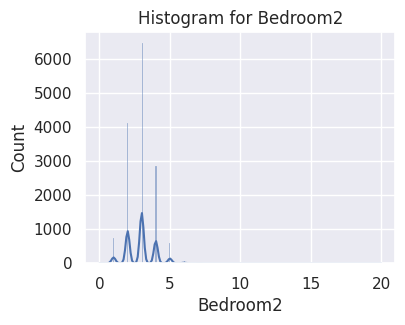

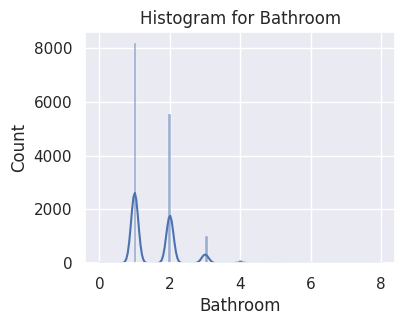

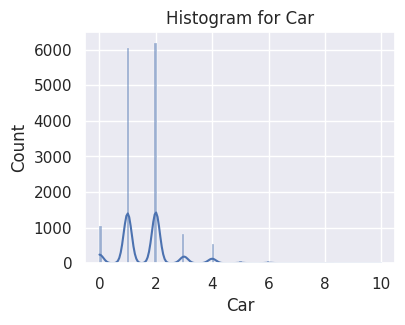

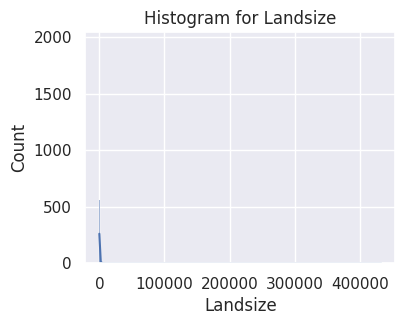

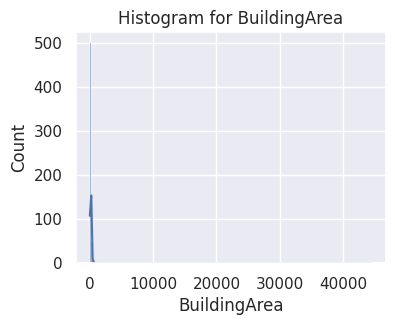

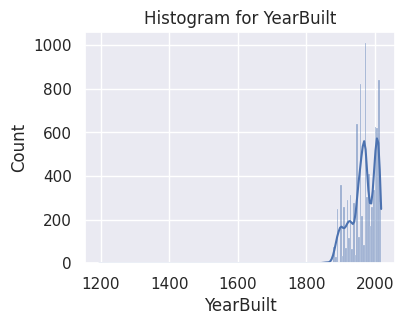

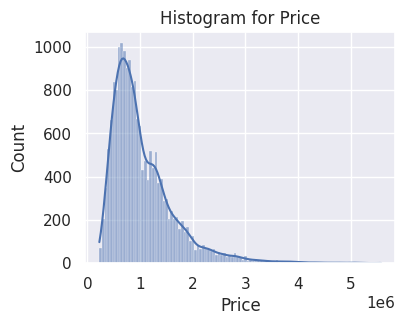

In [ ]:
for feature in features_with_nulls:
  sns.histplot(train[feature], kde=True)
  plt.title(f'Histogram for {feature}')  # Установка заголовка
  plt.show()

### **YearBuilt**
Сразу обращает на себя распределение по параметру **['YearBuilt']**

In [ ]:
train['YearBuilt'].min()

1196.0

Согласно [источнику](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D0%BB%D1%8C%D0%B1%D1%83%D1%80%D0%BD) Мельбурн был основан в 1835, городом стал в 1847. Зданий моложе этих дат быть не должно.

In [ ]:
train[train['YearBuilt'] <= 1847]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id
2710,Collingwood,2/79 Oxford St,2,u,855000.0,S,Nelson,3/09/2016,1.6,3066,...,1.0,2886.0,122.0,1830.0,Yarra City Council,-37.80420,144.98450,Northern Metropolitan,4553.0,18501
12721,Mount Waverley,5 Armstrong St,3,h,1200000.0,VB,McGrath,24/06/2017,14.2,3149,...,4.0,807.0,117.0,1196.0,Monash City Council,-37.86788,145.12121,Eastern Metropolitan,13366.0,11846


Заменим значения в таких данных

In [ ]:
train.loc[train['YearBuilt'] <= 1847, 'YearBuilt'] = 1847

Text(0.5, 1.0, 'Histogram for YearBuilt')

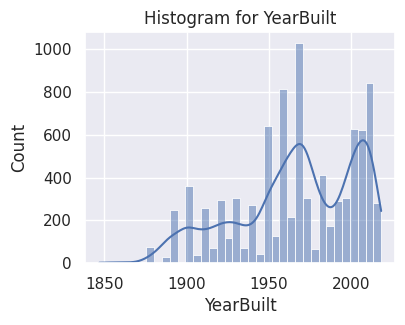

In [ ]:
sns.histplot(train['YearBuilt'], kde=True)
plt.title('Histogram for YearBuilt')

Так выглядит лучше

### **Landsize** и **BuildingArea**

В параметрах **Landsize** и **BuildingArea** тоже могут быть ошибки

In [ ]:
train['Landsize'].median(), train['Landsize'].max()

(440.0, 433014.0)

In [ ]:
train['BuildingArea'].median(), train['BuildingArea'].max()

(126.0, 44515.0)

В Австралии в ходу метрическая СИ. В случае с Landsize, можно себе представить поместье с земельным участком в 40 гектар.

А вот в здание с площадью в 6-7 футбольных полей верится не очень

In [ ]:
train[train['BuildingArea'] >= 5000]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id
1940,Bulleen,19 Warringal St,4,h,1280000.0,S,Barry,11/03/2017,11.8,3105,...,2.0,732.0,6791.0,NaN,Manningham City Council,-37.76150,145.08970,Eastern Metropolitan,4480.0,1116
17617,New Gisborne,71 Hamilton Rd,5,h,1355000.0,S,Raine,23/09/2017,48.1,3438,...,5.0,44500.0,44515.0,NaN,Macedon Ranges Shire Council,-37.45392,144.58864,Northern Victoria,849.0,14451


Сделаем допущение что это ошибка в единицах измерения.
Уменьшим это значение на два порядка

In [ ]:
train.loc[train['BuildingArea'] >= 15000, 'BuildingArea'] = train['BuildingArea']/100

### Параметры **'Rooms', 'Bedroom2', 'Bathroom'**

In [ ]:
train[['Rooms', 'Bedroom2', 'Bathroom']]

,Rooms,Bedroom2,Bathroom
0,2,2.0,1.0
1,2,2.0,1.0
2,3,3.0,2.0
3,3,3.0,2.0
4,4,3.0,1.0
...,...,...,...
18368,3,3.0,1.0
18369,3,3.0,1.0
18370,4,4.0,2.0
18371,3,3.0,2.0


In [ ]:
print(
    len(train.query('Bedroom2.notna()')),

    sum(train.query('Bedroom2.notna()')['Rooms'] == train.query('Bedroom2.notna()')['Bedroom2']))

14905 14224


В большинстве случаев где заполнено поле `['Bedroom2']`, ровно так же заполнено и поле `['Rooms']`


Сделаем тоже самое для полей, где это поле не заполнено `['Bedroom2']`

In [ ]:
train.loc[train['Bedroom2'].isna(), 'Bedroom2'] = train['Rooms']

In [ ]:
pd.crosstab(index=train['Rooms'], columns=train['Bathroom'])

Bathroom,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
Rooms,,,,,,,,,
1,1,726,6,0,0,0,0,0,0
2,19,3448,559,8,0,0,0,0,0
3,11,3506,2757,168,5,1,2,0,0
4,3,474,1905,521,45,2,0,0,1
5,0,17,280,264,49,25,2,1,0
6,0,2,20,43,9,1,0,0,0
7,0,0,4,6,2,0,0,0,0
8,0,0,2,2,2,0,1,1,1
10,0,0,0,1,0,0,0,0,0


Из кросстаблицы зависимости кол-ва комнат и кол-ва ванных комнат, видим что чаще всего в домах с тремя и менее комнатами - 1 санузел.

Заменим пропуски в случае с 4 и 5 комнатами - на 2 сануза. В случаях с более 5 комнатами - пропуски заменяем на 3 санузла.

Кроме того замечаем, что в базе есть дома "без удобств", что кажется странным для развитого города. Предлагаю заменить 0 на 1 в таких случаях.

In [ ]:
train.loc[(train['Bathroom'] == 0), 'Bathroom'] = 1
train.loc[(train['Bathroom'].isna()) & (train['Rooms'] <= 3), 'Bathroom'] = 1
train.loc[(train['Bathroom'].isna()) & (train['Rooms'] == 4), 'Bathroom'] = 2
train.loc[(train['Bathroom'].isna()) & (train['Rooms'] == 5), 'Bathroom'] = 2
train.loc[(train['Bathroom'].isna()) & ( train['Rooms'] > 5), 'Bathroom'] = 3

In [ ]:
pd.crosstab(index=train['Rooms'], columns=train['Bathroom'])

Bathroom,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
Rooms,,,,,,,,
1,880,6,0,0,0,0,0,0
2,4428,559,8,0,0,0,0,0
3,5025,2757,168,5,1,2,0,0
4,477,2600,521,45,2,0,0,1
5,17,410,264,49,25,2,1,0
6,2,20,58,9,1,0,0,0
7,0,4,7,2,0,0,0,0
8,0,2,4,2,0,1,1,1
9,0,0,1,0,0,0,0,0


### Car

In [ ]:
pd.crosstab(index=train['Rooms'], columns=train['Car'])

Car,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
Rooms,,,,,,,,,,,
1,99,612,14,1,3,0,0,0,0,0,0
2,437,2734,719,71,25,2,4,0,0,0,0
3,405,2160,3151,389,236,21,30,2,5,1,1
4,94,495,1833,268,195,30,16,4,6,0,2
5,13,50,419,65,65,13,10,1,1,0,0
6,1,5,41,11,14,0,2,1,0,0,0
7,1,1,3,1,5,0,0,0,0,0,0
8,0,1,0,2,6,0,0,0,0,0,0
10,0,0,1,0,0,0,0,0,0,0,0


Аналогично построим кросстаблицу зависимости кол-ва комнат и машиномест и попробуем ручным образом заменить пропуски

In [ ]:
train.loc[(train['Car'].isna()) & (train['Rooms'] <= 2), 'Car'] = 1
train.loc[(train['Car'].isna()) & (train['Rooms'] == 3), 'Car'] = 2
train.loc[(train['Car'].isna()) & (train['Rooms'] == 4), 'Car'] = 2
train.loc[(train['Car'].isna()) & (train['Rooms'] == 5), 'Car'] = 2
train.loc[(train['Car'].isna()) & (train['Rooms'] >= 6), 'Car'] = 3

## BuildingArea

Заполним пропуски, опираясь только на среднее (медиану) от кол-ва комнат

In [ ]:
train[['Rooms', 'BuildingArea']].groupby('Rooms').median()

,BuildingArea
Rooms,
1,50.0
2,85.0
3,129.0
4,190.0
5,260.0
6,266.0
7,335.5
8,152.5
9,NaN


Смущает уменьшение средней площади при увеличинии кол-ва комнат, после 7 шт. Заполним их медианой для 7 комнат + средняя площадь еще одной комнаты

In [ ]:
train.loc[(train['BuildingArea'].isna()) & (train['Rooms'] > 7), 'Car'] = (333.5 + (333.5/7))

Остальные пропуски заполняем медианными значениями по кол-ву комнат

In [ ]:
# Вычисляем среднее значение в каждой группе
group_means = train.groupby('Rooms')['BuildingArea'].transform('median')
train['BuildingArea'] = train['BuildingArea'].fillna(group_means)

Параметр **Landsize** решено пока оставить без заполнения пропусков, так как сложно сказать размер участка по размеру дома. Возможно в дальнейшем следует заполнить эти данные основываясь на средний размер участка в районе

In [ ]:
train_v2 = train

Закончим преобразование и сохраним этот датасет отдельно

In [ ]:
X = ['Suburb', 'Rooms', 'Type', 'Method', 'SellerG',
       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
     'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea',
     'Regionname', 'Propertycount']

cat_features = ['Suburb',
                #'Rooms',
                'Type', 'Method', 'SellerG', 'Postcode',
                #'Bedroom2', 'Bathroom', 'Car',
                'CouncilArea', 'Regionname',
                #'YearBuilt'
                ]

y = ['Price']

In [ ]:
# делаю валидационную выборку для оценки и проверки
val, train = train_test_split(train, train_size=0.2, random_state=7374)

val[cat_features] = val[cat_features].fillna(0)
train[cat_features] = train[cat_features].fillna(0)

In [ ]:
parameters = {'cat_features': cat_features,
              'loss_function': 'MAE',
              'eval_metric': 'MAPE',
              'learning_rate': 0.0777,
              'random_seed':7374,
              'verbose':100}

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y],eval_set=(val[X],val[y]))

0:	learn: 0.4047476	test: 0.3950126	best: 0.3950126 (0)	total: 36.4ms	remaining: 36.3s
100:	learn: 0.1591384	test: 0.1647857	best: 0.1647857 (100)	total: 2.61s	remaining: 23.3s
200:	learn: 0.1462177	test: 0.1553221	best: 0.1553221 (200)	total: 5.25s	remaining: 20.9s
300:	learn: 0.1397860	test: 0.1516449	best: 0.1516449 (300)	total: 9.03s	remaining: 21s
400:	learn: 0.1351543	test: 0.1497425	best: 0.1497296 (398)	total: 11.6s	remaining: 17.3s
500:	learn: 0.1316412	test: 0.1487855	best: 0.1487855 (500)	total: 14.2s	remaining: 14.2s
600:	learn: 0.1292408	test: 0.1484916	best: 0.1484863 (599)	total: 16.7s	remaining: 11.1s
700:	learn: 0.1270705	test: 0.1478723	best: 0.1478723 (700)	total: 19.9s	remaining: 8.48s
800:	learn: 0.1252471	test: 0.1474939	best: 0.1474367 (799)	total: 23s	remaining: 5.7s
900:	learn: 0.1237643	test: 0.1473045	best: 0.1472938 (896)	total: 25.5s	remaining: 2.8s
999:	learn: 0.1225067	test: 0.1473713	best: 0.1472859 (918)	total: 28s	remaining: 0us

bestTest = 0.147285866

In [ ]:
val['Price_pred_it3'] = model.predict(val[X])

In [ ]:
error(val['Price'],val['Price_pred_it3'])

164769.27661711033
0.14728586686429415


На валидационных данных ошибка МАРЕ выросла

Обучим модель на полной тренеровочной выборке и отправим очередной сабмит на кагл

In [ ]:
train = train_v2
train[cat_features] = train[cat_features].fillna(0)

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y])

0:	learn: 0.4027485	total: 31.1ms	remaining: 31.1s
100:	learn: 0.1587874	total: 3.18s	remaining: 28.3s
200:	learn: 0.1456106	total: 7.02s	remaining: 27.9s
300:	learn: 0.1394251	total: 9.85s	remaining: 22.9s
400:	learn: 0.1354080	total: 13.2s	remaining: 19.7s
500:	learn: 0.1322630	total: 17.3s	remaining: 17.2s
600:	learn: 0.1299453	total: 20.1s	remaining: 13.4s
700:	learn: 0.1280387	total: 23s	remaining: 9.8s
800:	learn: 0.1265741	total: 25.8s	remaining: 6.4s
900:	learn: 0.1251828	total: 29.8s	remaining: 3.27s
999:	learn: 0.1240622	total: 32.5s	remaining: 0us


In [ ]:
test['Price'] = model.predict(test[X])

In [ ]:
test[['id', 'Price']].to_csv('it_3.csv', index = False)

Score: **15.47294**

Скор сильно упал. Есть предположение что это из-за заполнения полей в высоким % изначальных пропусков. Попробую выполнить аналогичную предобработку, но без заполнения "BuildingArea"

# Итерация 3.2. Замена пропусков средним (медианой)

In [ ]:
train = pd.read_csv('/content/regression/train.csv')
train['Postcode'] = train['Postcode'].astype(int)

In [ ]:
# преобразование YearBuilt
train.loc[train['YearBuilt'] <= 1847, 'YearBuilt'] = 1847
# преобразование BuildingArea (только экстремумы (предположительно выбросы))
train.loc[train['BuildingArea'] >= 15000, 'BuildingArea'] = train['BuildingArea']/100
# преобразование Bedroom2
train.loc[train['Bedroom2'].isna(), 'Bedroom2'] = train['Rooms']
# преобразование Bathroom
train.loc[(train['Bathroom'] == 0), 'Bathroom'] = 1
train.loc[(train['Bathroom'].isna()) & (train['Rooms'] <= 3), 'Bathroom'] = 1
train.loc[(train['Bathroom'].isna()) & (train['Rooms'] == 4), 'Bathroom'] = 2
train.loc[(train['Bathroom'].isna()) & (train['Rooms'] == 5), 'Bathroom'] = 2
train.loc[(train['Bathroom'].isna()) & ( train['Rooms'] > 5), 'Bathroom'] = 3
# преобразование Car
train.loc[(train['Car'].isna()) & (train['Rooms'] <= 2), 'Car'] = 1
train.loc[(train['Car'].isna()) & (train['Rooms'] == 3), 'Car'] = 2
train.loc[(train['Car'].isna()) & (train['Rooms'] == 4), 'Car'] = 2
train.loc[(train['Car'].isna()) & (train['Rooms'] == 5), 'Car'] = 2
train.loc[(train['Car'].isna()) & (train['Rooms'] >= 6), 'Car'] = 3

Обучим модель сразу на всех тренировочных данных и загрузим сабмит на кагл на проверку

In [ ]:
train[cat_features] = train[cat_features].fillna(0)

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y])

0:	learn: 0.4027485	total: 39ms	remaining: 39s
100:	learn: 0.1604297	total: 2.93s	remaining: 26.1s
200:	learn: 0.1470482	total: 5.87s	remaining: 23.3s
300:	learn: 0.1402023	total: 9.96s	remaining: 23.1s
400:	learn: 0.1363800	total: 12.8s	remaining: 19.2s
500:	learn: 0.1332440	total: 15.7s	remaining: 15.6s
600:	learn: 0.1308817	total: 18.6s	remaining: 12.3s
700:	learn: 0.1289006	total: 22.7s	remaining: 9.66s
800:	learn: 0.1271621	total: 25.5s	remaining: 6.33s
900:	learn: 0.1259094	total: 28.4s	remaining: 3.12s
999:	learn: 0.1245949	total: 31.2s	remaining: 0us


In [ ]:
test['Price'] = model.predict(test[X])

In [ ]:
test[['id', 'Price']].to_csv('it_3_2.csv', index = False)

Score: **14.68058**

Предположение о том, что заменять просто средним/медианой значения столбцов с большим количеством пропусков подтвердилось. Скор поднялся (хотя на самом деле опустился). Однако улучшить рекордный свой результат не удалось(

## Итерация 3.2, но с обучением на валидационной выборке

In [ ]:
train = pd.read_csv('/content/regression/train.csv')

Заполним пропуски

In [ ]:
# преобразование YearBuilt
train.loc[train['YearBuilt'] <= 1847, 'YearBuilt'] = 1847
# преобразование BuildingArea (только экстремумы (предположительно выбросы))
train.loc[train['BuildingArea'] >= 15000, 'BuildingArea'] = train['BuildingArea']/100
# преобразование Bedroom2
train.loc[train['Bedroom2'].isna(), 'Bedroom2'] = train['Rooms']
# преобразование Bathroom
train.loc[(train['Bathroom'] == 0), 'Bathroom'] = 1
train.loc[(train['Bathroom'].isna()) & (train['Rooms'] <= 3), 'Bathroom'] = 1
train.loc[(train['Bathroom'].isna()) & (train['Rooms'] == 4), 'Bathroom'] = 2
train.loc[(train['Bathroom'].isna()) & (train['Rooms'] == 5), 'Bathroom'] = 2
train.loc[(train['Bathroom'].isna()) & ( train['Rooms'] > 5), 'Bathroom'] = 3
# преобразование Car
train.loc[(train['Car'].isna()) & (train['Rooms'] <= 2), 'Car'] = 1
train.loc[(train['Car'].isna()) & (train['Rooms'] == 3), 'Car'] = 2
train.loc[(train['Car'].isna()) & (train['Rooms'] == 4), 'Car'] = 2
train.loc[(train['Car'].isna()) & (train['Rooms'] == 5), 'Car'] = 2
train.loc[(train['Car'].isna()) & (train['Rooms'] >= 6), 'Car'] = 3

In [ ]:
# делаю валидационную выборку для оценки и проверки
val, train = train_test_split(train, train_size=0.2, random_state=7374)

In [ ]:

train[cat_features] = train[cat_features].fillna(0)
val[cat_features] = val[cat_features].fillna(0)
test[cat_features] = test[cat_features].fillna(0)

train['Postcode'] = train['Postcode'].astype(int)
val['Postcode'] = val['Postcode'].astype(int)
test['Postcode'] = test['Postcode'].astype(int)


In [ ]:
X = ['Suburb', 'Rooms', 'Type', 'Method', 'SellerG',
       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
     'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea',
     'Regionname', 'Propertycount']

cat_features = ['Suburb',
                'Type', 'Method', 'SellerG', 'Postcode',
                'CouncilArea', 'Regionname',
                ]

y = ['Price']

In [ ]:
parameters = {'cat_features': cat_features,
              'loss_function': 'MAE',
              'eval_metric': 'MAPE',
              'learning_rate': 0.067,
              'random_seed':7374,
              'verbose':100}

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y],eval_set=(val[X],val[y]))

0:	learn: 0.4078875	test: 0.3980792	best: 0.3980792 (0)	total: 30ms	remaining: 30s
100:	learn: 0.1638233	test: 0.1674772	best: 0.1674772 (100)	total: 2.57s	remaining: 22.9s
200:	learn: 0.1489511	test: 0.1562900	best: 0.1562900 (200)	total: 6.04s	remaining: 24s
300:	learn: 0.1419985	test: 0.1523249	best: 0.1523249 (300)	total: 9s	remaining: 20.9s
400:	learn: 0.1374223	test: 0.1503690	best: 0.1503664 (399)	total: 12.8s	remaining: 19.1s
500:	learn: 0.1341653	test: 0.1494268	best: 0.1493552 (488)	total: 18.1s	remaining: 18s
600:	learn: 0.1312817	test: 0.1486813	best: 0.1486813 (600)	total: 22.1s	remaining: 14.7s
700:	learn: 0.1290827	test: 0.1482089	best: 0.1482089 (700)	total: 24.7s	remaining: 10.5s
800:	learn: 0.1271059	test: 0.1478762	best: 0.1478762 (800)	total: 27.3s	remaining: 6.78s
900:	learn: 0.1255146	test: 0.1478422	best: 0.1478407 (896)	total: 30.1s	remaining: 3.3s
999:	learn: 0.1240437	test: 0.1476419	best: 0.1476414 (998)	total: 33.4s	remaining: 0us

bestTest = 0.1476413805
be

In [ ]:
bestTest = 0.1468530056
bestIteration = 997

In [ ]:
test['Price'] = model.predict(test[X])

In [ ]:
test[['id', 'Price']].to_csv('it_3_2_val.csv', index = False)

Score: **15.1647**


## Итерация 3.2, но с обучением на валидационной выборке и заполнением пропусков в тестовых данных

In [ ]:
train = pd.read_csv('/content/regression/train.csv')
test = pd.read_csv('/content/regression/test.csv')

Заполним пропуски

In [ ]:
# преобразование YearBuilt
train.loc[train['YearBuilt'] <= 1847, 'YearBuilt'] = 1847
# преобразование BuildingArea (только экстремумы (предположительно выбросы))
train.loc[train['BuildingArea'] >= 15000, 'BuildingArea'] = train['BuildingArea']/100
# преобразование Bedroom2
train.loc[train['Bedroom2'].isna(), 'Bedroom2'] = train['Rooms']
# преобразование Bathroom
train.loc[(train['Bathroom'] == 0), 'Bathroom'] = 1
train.loc[(train['Bathroom'].isna()) & (train['Rooms'] <= 3), 'Bathroom'] = 1
train.loc[(train['Bathroom'].isna()) & (train['Rooms'] == 4), 'Bathroom'] = 2
train.loc[(train['Bathroom'].isna()) & (train['Rooms'] == 5), 'Bathroom'] = 2
train.loc[(train['Bathroom'].isna()) & ( train['Rooms'] > 5), 'Bathroom'] = 3
# преобразование Car
train.loc[(train['Car'].isna()) & (train['Rooms'] <= 2), 'Car'] = 1
train.loc[(train['Car'].isna()) & (train['Rooms'] == 3), 'Car'] = 2
train.loc[(train['Car'].isna()) & (train['Rooms'] == 4), 'Car'] = 2
train.loc[(train['Car'].isna()) & (train['Rooms'] == 5), 'Car'] = 2
train.loc[(train['Car'].isna()) & (train['Rooms'] >= 6), 'Car'] = 3


# преобразование YearBuilt
test.loc[test['YearBuilt'] <= 1847, 'YearBuilt'] = 1847
# преобразование BuildingArea (только экстремумы (предположительно выбросы))
test.loc[test['BuildingArea'] >= 15000, 'BuildingArea'] = test['BuildingArea']/100
# преобразование Bedroom2
test.loc[test['Bedroom2'].isna(), 'Bedroom2'] = test['Rooms']
# преобразование Bathroom
test.loc[(test['Bathroom'] == 0), 'Bathroom'] = 1
test.loc[(test['Bathroom'].isna()) & (test['Rooms'] <= 3), 'Bathroom'] = 1
test.loc[(test['Bathroom'].isna()) & (test['Rooms'] == 4), 'Bathroom'] = 2
test.loc[(test['Bathroom'].isna()) & (test['Rooms'] == 5), 'Bathroom'] = 2
test.loc[(test['Bathroom'].isna()) & (test['Rooms'] > 5), 'Bathroom'] = 3
# преобразование Car
test.loc[(test['Car'].isna()) & (test['Rooms'] <= 2), 'Car'] = 1
test.loc[(test['Car'].isna()) & (test['Rooms'] == 3), 'Car'] = 2
test.loc[(test['Car'].isna()) & (test['Rooms'] == 4), 'Car'] = 2
test.loc[(test['Car'].isna()) & (test['Rooms'] == 5), 'Car'] = 2
test.loc[(test['Car'].isna()) & (test['Rooms'] >= 6), 'Car'] = 3

In [ ]:
# делаю валидационную выборку для оценки и проверки
val, train = train_test_split(train, train_size=0.2, random_state=7374)

In [ ]:
train[cat_features] = train[cat_features].fillna(0)
val[cat_features] = val[cat_features].fillna(0)
test[cat_features] = test[cat_features].fillna(0)

train['Postcode'] = train['Postcode'].astype(int)
val['Postcode'] = val['Postcode'].astype(int)
test['Postcode'] = test['Postcode'].astype(int)

In [ ]:
X = ['Suburb', 'Rooms', 'Type', 'Method', 'SellerG',
       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
     'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea',
     'Regionname', 'Propertycount']

cat_features = ['Suburb',
                'Type', 'Method', 'SellerG', 'Postcode',
                'CouncilArea', 'Regionname']

y = ['Price']

In [ ]:
parameters = {'cat_features': cat_features,
              'loss_function': 'MAE',
              'eval_metric': 'MAPE',
              'learning_rate': 0.1,
              'random_seed':7374,
              'verbose':100}

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y],eval_set=(val[X],val[y]))

0:	learn: 0.3982608	test: 0.3886893	best: 0.3886893 (0)	total: 30.4ms	remaining: 30.3s
100:	learn: 0.1553890	test: 0.1596939	best: 0.1596939 (100)	total: 2.71s	remaining: 24.1s
200:	learn: 0.1425792	test: 0.1516398	best: 0.1516398 (200)	total: 5.44s	remaining: 21.6s
300:	learn: 0.1356545	test: 0.1494736	best: 0.1494736 (300)	total: 9.22s	remaining: 21.4s
400:	learn: 0.1315008	test: 0.1489254	best: 0.1488466 (332)	total: 11.9s	remaining: 17.7s
500:	learn: 0.1281773	test: 0.1483195	best: 0.1482956 (488)	total: 14.4s	remaining: 14.4s
600:	learn: 0.1258185	test: 0.1485115	best: 0.1482651 (541)	total: 17s	remaining: 11.3s
700:	learn: 0.1235674	test: 0.1481595	best: 0.1481329 (663)	total: 20.2s	remaining: 8.63s
800:	learn: 0.1217132	test: 0.1480574	best: 0.1480380 (798)	total: 23.4s	remaining: 5.81s
900:	learn: 0.1200769	test: 0.1480751	best: 0.1480380 (798)	total: 25.9s	remaining: 2.85s
999:	learn: 0.1188241	test: 0.1478501	best: 0.1478285 (987)	total: 28.4s	remaining: 0us

bestTest = 0.147

In [ ]:
test['Price'] = model.predict(test[X])

In [ ]:
test[['id', 'Price']].to_csv('it_3_2_val_t.csv', index = False)

# Итерация 4, Заполнение пропусков, но только для тестовых данных

In [ ]:
train = pd.read_csv('/content/regression/train.csv')
test = pd.read_csv('/content/regression/test.csv')

Заполним пропуски

In [ ]:
# преобразование YearBuilt
test.loc[test['YearBuilt'] <= 1847, 'YearBuilt'] = 1847
# преобразование BuildingArea (только экстремумы (предположительно выбросы))
test.loc[test['BuildingArea'] >= 15000, 'BuildingArea'] = test['BuildingArea']/100
# преобразование Bedroom2
test.loc[test['Bedroom2'].isna(), 'Bedroom2'] = test['Rooms']
# преобразование Bathroom
test.loc[(test['Bathroom'] == 0), 'Bathroom'] = 1
test.loc[(test['Bathroom'].isna()) & (test['Rooms'] <= 3), 'Bathroom'] = 1
test.loc[(test['Bathroom'].isna()) & (test['Rooms'] == 4), 'Bathroom'] = 2
test.loc[(test['Bathroom'].isna()) & (test['Rooms'] == 5), 'Bathroom'] = 2
test.loc[(test['Bathroom'].isna()) & (test['Rooms'] > 5), 'Bathroom'] = 3
# преобразование Car
test.loc[(test['Car'].isna()) & (test['Rooms'] <= 2), 'Car'] = 1
test.loc[(test['Car'].isna()) & (test['Rooms'] == 3), 'Car'] = 2
test.loc[(test['Car'].isna()) & (test['Rooms'] == 4), 'Car'] = 2
test.loc[(test['Car'].isna()) & (test['Rooms'] == 5), 'Car'] = 2
test.loc[(test['Car'].isna()) & (test['Rooms'] >= 6), 'Car'] = 3

In [ ]:
# делаю валидационную выборку для оценки и проверки
val, train = train_test_split(train, train_size=0.2, random_state=7374)

In [ ]:
train[cat_features] = train[cat_features].fillna(0)
val[cat_features] = val[cat_features].fillna(0)
test[cat_features] = test[cat_features].fillna(0)

train['Postcode'] = train['Postcode'].astype(int)
val['Postcode'] = val['Postcode'].astype(int)
test['Postcode'] = test['Postcode'].astype(int)

In [ ]:
X = ['Suburb', 'Rooms', 'Type', 'Method', 'SellerG',
       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
     'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea',
     'Regionname', 'Propertycount']

cat_features = ['Suburb',
                'Type', 'Method', 'SellerG', 'Postcode',
                'CouncilArea', 'Regionname']

y = ['Price']

В параметрах поменял `learning_rate`

In [ ]:
parameters = {'cat_features': cat_features,
              'loss_function': 'MAE',
              'eval_metric': 'MAPE',
              'learning_rate': 0.08939,
              'random_seed':7374,
              'verbose':100}

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y],eval_set=(val[X],val[y]))

0:	learn: 0.4023928	test: 0.3925921	best: 0.3925921 (0)	total: 31ms	remaining: 31s
100:	learn: 0.1601943	test: 0.1638098	best: 0.1638098 (100)	total: 2.62s	remaining: 23.3s
200:	learn: 0.1453654	test: 0.1540451	best: 0.1540451 (200)	total: 5.33s	remaining: 21.2s
300:	learn: 0.1384983	test: 0.1511478	best: 0.1511478 (300)	total: 9.85s	remaining: 22.9s
400:	learn: 0.1339027	test: 0.1493672	best: 0.1493672 (400)	total: 12.4s	remaining: 18.6s
500:	learn: 0.1303034	test: 0.1482925	best: 0.1482693 (497)	total: 15s	remaining: 15s
600:	learn: 0.1276092	test: 0.1478754	best: 0.1478754 (600)	total: 17.6s	remaining: 11.7s
700:	learn: 0.1253584	test: 0.1473950	best: 0.1473677 (680)	total: 21.4s	remaining: 9.12s
800:	learn: 0.1233564	test: 0.1472665	best: 0.1472296 (789)	total: 23.9s	remaining: 5.94s
900:	learn: 0.1217550	test: 0.1470168	best: 0.1469322 (887)	total: 26.5s	remaining: 2.91s
999:	learn: 0.1204665	test: 0.1468850	best: 0.1468850 (999)	total: 29s	remaining: 0us

bestTest = 0.1468849943


In [ ]:
test['Price'] = model.predict(test[X])

In [ ]:
test[['id', 'Price']].to_csv('it_4.csv', index = False)

Score: **14.0587**

Опытным путем дошел до того, что ручное заполнение пропусков имеет смысл только в тестовых данных

Обучим на всех данных и изменим параметры модели (learning_rate)

In [ ]:
train = pd.read_csv('/content/regression/train.csv')
test = pd.read_csv('/content/regression/test.csv')

Заполним пропуски

In [ ]:
# преобразование YearBuilt
train.loc[train['YearBuilt'] <= 1847, 'YearBuilt'] = 1847
# преобразование BuildingArea (только экстремумы (предположительно выбросы))
train.loc[train['BuildingArea'] >= 15000, 'BuildingArea'] = test['BuildingArea']/100

# преобразование YearBuilt
test.loc[test['YearBuilt'] <= 1847, 'YearBuilt'] = 1847
# преобразование BuildingArea (только экстремумы (предположительно выбросы))
test.loc[test['BuildingArea'] >= 15000, 'BuildingArea'] = test['BuildingArea']/100
# преобразование Bedroom2
test.loc[test['Bedroom2'].isna(), 'Bedroom2'] = test['Rooms']
# преобразование Bathroom
test.loc[(test['Bathroom'] == 0), 'Bathroom'] = 1
test.loc[(test['Bathroom'].isna()) & (test['Rooms'] <= 3), 'Bathroom'] = 1
test.loc[(test['Bathroom'].isna()) & (test['Rooms'] == 4), 'Bathroom'] = 2
test.loc[(test['Bathroom'].isna()) & (test['Rooms'] == 5), 'Bathroom'] = 2
test.loc[(test['Bathroom'].isna()) & (test['Rooms'] > 5), 'Bathroom'] = 3
# преобразование Car
test.loc[(test['Car'].isna()) & (test['Rooms'] <= 2), 'Car'] = 1
test.loc[(test['Car'].isna()) & (test['Rooms'] == 3), 'Car'] = 2
test.loc[(test['Car'].isna()) & (test['Rooms'] == 4), 'Car'] = 2
test.loc[(test['Car'].isna()) & (test['Rooms'] == 5), 'Car'] = 2
test.loc[(test['Car'].isna()) & (test['Rooms'] >= 6), 'Car'] = 3

In [ ]:
train[cat_features] = train[cat_features].fillna(0)
test[cat_features] = test[cat_features].fillna(0)

train['Postcode'] = train['Postcode'].astype(int)
test['Postcode'] = test['Postcode'].astype(int)

In [ ]:
X = ['Suburb', 'Rooms', 'Type', 'Method', 'SellerG',
       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
     'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea',
     'Regionname', 'Propertycount']

cat_features = ['Suburb',
                'Type', 'Method', 'SellerG', 'Postcode',
                'CouncilArea', 'Regionname']

y = ['Price']

In [ ]:
parameters = {'cat_features': cat_features,
              'loss_function': 'MAE',
              'eval_metric': 'MAPE',
              'learning_rate': 0.08939,
              'random_seed':7374,
              'verbose':100}

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y])

0:	learn: 0.3998107	total: 31.6ms	remaining: 31.6s
100:	learn: 0.1589111	total: 2.94s	remaining: 26.2s
200:	learn: 0.1447970	total: 5.99s	remaining: 23.8s
300:	learn: 0.1386747	total: 9.04s	remaining: 21s
400:	learn: 0.1348992	total: 13.2s	remaining: 19.7s
500:	learn: 0.1315498	total: 16.1s	remaining: 16.1s
600:	learn: 0.1290342	total: 19.2s	remaining: 12.7s
700:	learn: 0.1271070	total: 22.8s	remaining: 9.72s
800:	learn: 0.1254277	total: 26.1s	remaining: 6.49s
900:	learn: 0.1242756	total: 29s	remaining: 3.18s
999:	learn: 0.1230460	total: 31.8s	remaining: 0us


In [ ]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Rooms,14.725140
1,Distance,14.354019
2,Type,13.180037
3,CouncilArea,10.125342
4,Landsize,7.678623
5,Postcode,6.737118
6,BuildingArea,6.634642
7,Regionname,6.134588
8,Bathroom,5.342557
9,SellerG,4.403690


In [ ]:
test['Price'] = model.predict(test[X])

In [ ]:
test[['id', 'Price']].to_csv('it_4_2.csv', index = False)

Score: **13.80384**


# Итерация 5. Заполнение пропусков в категориальных переменных `CouncilArea`, `Regionname`,`Postcode`.

In [ ]:
train = pd.read_csv('/content/regression/train.csv')
test = pd.read_csv('/content/regression/test.csv')

Text(0.5, 1.0, 'Histogram for YearBuilt')

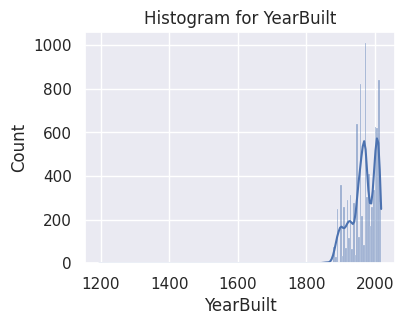

In [ ]:
sns.histplot(train['YearBuilt'], kde=True)
plt.title('Histogram for YearBuilt')

Text(0.5, 1.0, 'Histogram for YearBuilt')

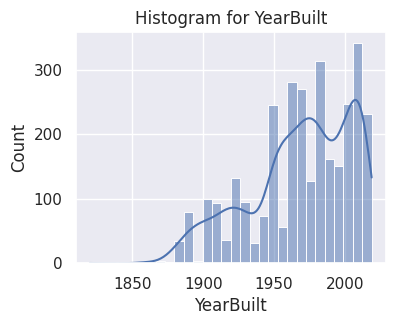

In [ ]:
sns.histplot(test['YearBuilt'], kde=True)
plt.title('Histogram for YearBuilt')

In [ ]:
# преобразование YearBuilt, там с большой долей вероятности есть выбросы
test.loc[test['YearBuilt'] <= 1847, 'YearBuilt'] = 1847

In [ ]:
test.isna().mean()

Suburb           0.000000
Address          0.000000
Rooms            0.000000
Type             0.000000
Method           0.000000
SellerG          0.000000
Date             0.000000
Distance         0.000113
Postcode         0.000113
Bedroom2         0.335677
Bathroom         0.336131
Car              0.366977
Landsize         0.504990
BuildingArea     0.673169
YearBuilt        0.647086
CouncilArea      0.000227
Lattitude        0.330007
Longtitude       0.330007
Regionname       0.000227
Propertycount    0.000227
id               0.000000
dtype: float64

In [ ]:
test[test['Regionname'].isna()]

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,...,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id
2634,Camberwell,2/3 Kingsley St,2,h,VB,Jellis,11/11/2017,7.7,3124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15921
4628,Fawkner Lot,1/3 Brian St,3,h,SP,Brad,6/01/2018,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33262


Вычислим заполнения для строки с id = 2634. По имеющемуся `Postcode` заполним `CouncilArea, Regionname, Propertycount`

In [ ]:
print(
    test['CouncilArea'][test['Postcode'] == 3124].mode()[0],
    test['Regionname'][test['Postcode'] == 3124].mode()[0],
    test['Propertycount'][test['Postcode'] == 3124].mode()[0]
    )

Boroondara City Council Southern Metropolitan 8920.0


In [ ]:
# Заполняем значения ячеек по индексу строки
test.loc[2634, 'CouncilArea'] = 'Boroondara City Council'
test.loc[2634, 'Regionname'] = 'Southern Metropolitan'
test.loc[2634, 'Propertycount'] = 8920

Аналогично заполнис пропуски в отдельной строке в train

In [ ]:
train[train['Regionname'].isna()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id
14406,Footscray,2/16 Stafford St,2,u,710000.0,S,Jas,15/07/2017,5.1,3011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21235


In [ ]:
print(
    train['CouncilArea'][train['Postcode'] == 3011].mode()[0],
    train['Regionname'][train['Postcode'] == 3011].mode()[0],
    train['Propertycount'][train['Postcode'] == 3011].mode()[0]
    )

Maribyrnong City Council Western Metropolitan 7570.0


In [ ]:
# Заполняем значения ячеек по индексу строки
train.loc[14406, 'CouncilArea'] = 'Maribyrnong City Council'
train.loc[14406, 'Regionname'] = 'Western Metropolitan'
train.loc[14406, 'Propertycount'] = 7570

In [ ]:
train[train['Regionname'].isna()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id


In [ ]:
test.isna().mean()

Suburb           0.000000
Address          0.000000
Rooms            0.000000
Type             0.000000
Method           0.000000
SellerG          0.000000
Date             0.000000
Distance         0.000113
Postcode         0.000113
Bedroom2         0.335677
Bathroom         0.336131
Car              0.366977
Landsize         0.504990
BuildingArea     0.673169
YearBuilt        0.647086
CouncilArea      0.000113
Lattitude        0.330007
Longtitude       0.330007
Regionname       0.000113
Propertycount    0.000113
id               0.000000
dtype: float64

In [ ]:
train.isna().mean()

Suburb           0.000000
Address          0.000000
Rooms            0.000000
Type             0.000000
Price            0.000000
Method           0.000000
SellerG          0.000000
Date             0.000000
Distance         0.000000
Postcode         0.000000
Bedroom2         0.188755
Bathroom         0.188864
Car              0.194579
Landsize         0.260926
BuildingArea     0.578185
YearBuilt        0.513199
CouncilArea      0.000000
Lattitude        0.181353
Longtitude       0.181353
Regionname       0.000000
Propertycount    0.000000
id               0.000000
dtype: float64

In [ ]:
train[train['Address'].str.contains('Brian St')]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id
1121,Bentleigh East,1A Brian St,4,t,1185000.0,S,hockingstuart,10/12/2016,13.9,3165.0,...,2.0,305.0,207.0,2012.0,Glen Eira City Council,-37.9245,145.0507,Southern Metropolitan,10969.0,13328
8750,Fawkner,3 Brian St,3,h,625000.0,S,Brad,10/12/2016,12.4,3060.0,...,2.0,585.0,88.0,1960.0,Hume City Council,-37.6950,144.9676,Northern Metropolitan,5070.0,24826
9907,Fawkner,3 Brian St,3,h,660000.0,S,Brad,8/04/2017,12.4,3060.0,...,2.0,585.0,88.0,1960.0,Hume City Council,-37.6950,144.9676,Northern Metropolitan,5070.0,20675


In [ ]:
test[test['Address'].str.contains('Brian St')]

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,...,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id
4628,Fawkner Lot,1/3 Brian St,3,h,SP,Brad,6/01/2018,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33262
7171,Mitcham,1 Brian St,3,h,S,Philip,17/02/2018,17.2,3132.0,3.0,...,1.0,630.0,110.0,1950.0,Whitehorse City Council,-37.82505,145.18797,Eastern Metropolitan,6871.0,22739


Заполним значения строки **4628** тестового датасета значениями по полю `Suburb` датасета train. Будем считать что улица 'Brian St' одна и та же в обоих датасетах в районе Fawkner

In [ ]:
# Заполняем значения ячеек по индексу строки
test.loc[4628, 'CouncilArea'] = 'Hume City Council'
test.loc[4628, 'Regionname'] = 'Northern Metropolitan'
test.loc[4628, 'Propertycount'] = 5070
test.loc[4628, 'Postcode'] = 3060

На этом остановимся. Обучим модель по параметрам из самой лучшей итерации и сделаем новый сабмит.

In [ ]:
X = ['Suburb', 'Rooms', 'Type', 'Method', 'SellerG',
       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
     'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea',
     'Regionname', 'Propertycount']

cat_features = ['Suburb',
                'Type', 'Method', 'SellerG', 'Postcode',
                'CouncilArea', 'Regionname',
                ]

y = ['Price']

In [ ]:
train['Postcode'] = train['Postcode'].astype(int)
test['Postcode'] = test['Postcode'].astype(int)

In [ ]:
# делаю валидационную выборку для оценки и проверки
val, train = train_test_split(train, train_size=0.2, random_state=7374)

val[cat_features] = val[cat_features].fillna(0)
train[cat_features] = train[cat_features].fillna(0)

In [ ]:
parameters = {'cat_features': cat_features,
              'loss_function': 'MAE',
              'eval_metric': 'MAPE',
              'learning_rate': 0.0777,
              'random_seed':7374,
              'verbose':100}

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y],eval_set=(val[X],val[y]))

0:	learn: 0.4056706	test: 0.3958092	best: 0.3958092 (0)	total: 45.4ms	remaining: 45.4s
100:	learn: 0.1621948	test: 0.1648190	best: 0.1648190 (100)	total: 3.55s	remaining: 31.6s
200:	learn: 0.1479702	test: 0.1550451	best: 0.1550451 (200)	total: 6.05s	remaining: 24.1s
300:	learn: 0.1406681	test: 0.1512081	best: 0.1511955 (296)	total: 8.58s	remaining: 19.9s
400:	learn: 0.1362462	test: 0.1493074	best: 0.1493074 (400)	total: 11.1s	remaining: 16.5s
500:	learn: 0.1328922	test: 0.1485619	best: 0.1484982 (490)	total: 14.7s	remaining: 14.6s
600:	learn: 0.1301287	test: 0.1479494	best: 0.1479494 (600)	total: 17.1s	remaining: 11.4s
700:	learn: 0.1275577	test: 0.1473920	best: 0.1473913 (699)	total: 19.6s	remaining: 8.36s
800:	learn: 0.1255810	test: 0.1472575	best: 0.1472575 (800)	total: 22s	remaining: 5.47s
900:	learn: 0.1239677	test: 0.1470592	best: 0.1470097 (889)	total: 24.4s	remaining: 2.68s
999:	learn: 0.1228481	test: 0.1470509	best: 0.1470029 (960)	total: 27.8s	remaining: 0us

bestTest = 0.147

In [ ]:
val['Price_pred_it1_1'] = model.predict(val[X])

In [ ]:
error(val['Price'],val['Price_pred_it1_1'])

164634.80179970778
0.1470028910950025


Обучим с этим набором фич/параметров модель на всех train данных и сделаем еще сабмит

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y])

0:	learn: 0.4056706	total: 26.4ms	remaining: 26.4s
100:	learn: 0.1621948	total: 2.32s	remaining: 20.6s
200:	learn: 0.1479702	total: 4.64s	remaining: 18.4s
300:	learn: 0.1406681	total: 6.93s	remaining: 16.1s
400:	learn: 0.1362462	total: 9.94s	remaining: 14.8s
500:	learn: 0.1328922	total: 12.7s	remaining: 12.7s
600:	learn: 0.1301287	total: 15s	remaining: 9.97s
700:	learn: 0.1275577	total: 17.3s	remaining: 7.38s
800:	learn: 0.1255810	total: 19.6s	remaining: 4.86s
900:	learn: 0.1239677	total: 22.8s	remaining: 2.51s
999:	learn: 0.1228481	total: 25.1s	remaining: 0us


In [ ]:
train[cat_features] = train[cat_features].fillna(0)

In [ ]:
test['Price'] = model.predict(test[X])

In [ ]:
test[['id', 'Price']].to_csv('it_5.csv', index = False)

Score: **13.98718**

Заполнив пропуски вручнуюи только в отдельных строках, не получилось улучшить собственный результат

# Итерация 6. С изменение loss_function

In [ ]:
X = ['Suburb', 'Rooms', 'Type', 'Method', 'SellerG',
       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
     'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea',
     'Regionname', 'Propertycount']

cat_features = ['Suburb',
                'Type', 'Method', 'SellerG', 'Postcode',
                'CouncilArea', 'Regionname',
                ]

y = ['Price']

In [ ]:
train = pd.read_csv('/content/regression/train.csv')

In [ ]:
train['Postcode'] = train['Postcode'].astype(int)
train[cat_features] = train[cat_features].fillna(0)

In [ ]:
# делаю валидационную выборку для оценки и проверки
val, train = train_test_split(train, train_size=0.2, random_state=7374)

val[cat_features] = val[cat_features].fillna(0)
train[cat_features] = train[cat_features].fillna(0)

In [ ]:
parameters = {'cat_features': cat_features,
              'loss_function': 'MAE', # Измененный  параметр относительно наилучшей итерации
              'eval_metric': 'MAPE',
              'learning_rate': 0.077, # Измененный  параметр относительно наилучшей итерации (было 0.0777)
              'random_seed':7374,
              'verbose':100}

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y],eval_set=(val[X],val[y]))

0:	learn: 0.4058673	test: 0.3959963	best: 0.3959963 (0)	total: 33.2ms	remaining: 33.2s
100:	learn: 0.1628287	test: 0.1660514	best: 0.1660514 (100)	total: 2.52s	remaining: 22.5s
200:	learn: 0.1470824	test: 0.1542652	best: 0.1542652 (200)	total: 6.22s	remaining: 24.7s
300:	learn: 0.1400594	test: 0.1501505	best: 0.1501505 (300)	total: 8.67s	remaining: 20.1s
400:	learn: 0.1357076	test: 0.1488933	best: 0.1488933 (400)	total: 11.2s	remaining: 16.7s
500:	learn: 0.1323706	test: 0.1482673	best: 0.1482570 (499)	total: 13.6s	remaining: 13.6s
600:	learn: 0.1298295	test: 0.1477767	best: 0.1477767 (600)	total: 16.9s	remaining: 11.2s
700:	learn: 0.1272554	test: 0.1472692	best: 0.1472021 (697)	total: 19.7s	remaining: 8.4s
800:	learn: 0.1251499	test: 0.1469650	best: 0.1468358 (771)	total: 22.1s	remaining: 5.5s
900:	learn: 0.1234897	test: 0.1466957	best: 0.1466304 (884)	total: 24.5s	remaining: 2.69s
999:	learn: 0.1220903	test: 0.1464182	best: 0.1463972 (996)	total: 26.9s	remaining: 0us

bestTest = 0.146

In [ ]:
val['Price_pred_it1_1'] = model.predict(val[X])

In [ ]:
error(val['Price'],val['Price_pred_it1_1'])

163790.94968423047
0.1463971624132058


Улучшился результат по МАРЕ

Попробуем обучить с этим набором фич/параметров модель на всех train данных и сделать еще сабмит

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y])

0:	learn: 0.4058673	total: 26.5ms	remaining: 26.4s
100:	learn: 0.1628287	total: 3.54s	remaining: 31.5s
200:	learn: 0.1470824	total: 5.92s	remaining: 23.5s
300:	learn: 0.1400594	total: 8.23s	remaining: 19.1s
400:	learn: 0.1357076	total: 10.6s	remaining: 15.8s
500:	learn: 0.1323706	total: 13.2s	remaining: 13.2s
600:	learn: 0.1298295	total: 16.3s	remaining: 10.9s
700:	learn: 0.1272554	total: 18.7s	remaining: 7.96s
800:	learn: 0.1251499	total: 20.9s	remaining: 5.2s
900:	learn: 0.1234897	total: 23.2s	remaining: 2.55s
999:	learn: 0.1220903	total: 27.8s	remaining: 0us


In [ ]:
test = pd.read_csv('/content/regression/test.csv')
test['Postcode'] = test['Postcode'].astype(int)
test[cat_features] = test[cat_features].fillna(0)

In [ ]:
test['Price'] = model.predict(test[X])

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=6]=3067.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [ ]:
test[['id', 'Price']].to_csv('it_6_MAE.csv', index = False)

Score: **20.06784** - lossfunction **RMSE** Ошибочный ('learning_rate': 0.92)  
Score: **14.73896** - lossfunction **RMSE** Ошибочный ('learning_rate': 0.092)

# Итерация 7. Подбор параметров с помощью grid

## Предобработка

In [ ]:
X = ['Suburb', 'Rooms', 'Type', 'Method', 'SellerG',
       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
     'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea',
     'Regionname', 'Propertycount']

cat_features = ['Suburb',
                'Type', 'Method', 'SellerG', 'Postcode',
                'CouncilArea', 'Regionname',
                ]

y = ['Price']

In [ ]:
train = pd.read_csv('/content/regression/train.csv')
train['Postcode'] = train['Postcode'].astype(int)
train[cat_features] = train[cat_features].fillna(0)

In [ ]:
test = pd.read_csv('/content/regression/test.csv')
test[cat_features] = test[cat_features].fillna(0)
test['Postcode'] = test['Postcode'].astype(int)

In [ ]:
train.loc[train['YearBuilt'] <= 1847, 'YearBuilt'] = 1847
test.loc[test['YearBuilt'] <= 1847, 'YearBuilt'] = 1847


# преобразование YearBuilt
test.loc[test['YearBuilt'] <= 1847, 'YearBuilt'] = 1847
# преобразование BuildingArea (только экстремумы (предположительно выбросы))
test.loc[test['BuildingArea'] >= 15000, 'BuildingArea'] = test['BuildingArea']/100
# преобразование Bedroom2
test.loc[test['Bedroom2'].isna(), 'Bedroom2'] = test['Rooms']
# преобразование Bathroom
test.loc[(test['Bathroom'] == 0), 'Bathroom'] = 1
test.loc[(test['Bathroom'].isna()) & (test['Rooms'] <= 3), 'Bathroom'] = 1
test.loc[(test['Bathroom'].isna()) & (test['Rooms'] == 4), 'Bathroom'] = 2
test.loc[(test['Bathroom'].isna()) & (test['Rooms'] == 5), 'Bathroom'] = 2
test.loc[(test['Bathroom'].isna()) & (test['Rooms'] > 5), 'Bathroom'] = 3
# преобразование Car
test.loc[(test['Car'].isna()) & (test['Rooms'] <= 2), 'Car'] = 1
test.loc[(test['Car'].isna()) & (test['Rooms'] == 3), 'Car'] = 2
test.loc[(test['Car'].isna()) & (test['Rooms'] == 4), 'Car'] = 2
test.loc[(test['Car'].isna()) & (test['Rooms'] == 5), 'Car'] = 2
test.loc[(test['Car'].isna()) & (test['Rooms'] >= 6), 'Car'] = 3

# Заполняем значения ячеек по индексу строки
test.loc[2634, 'CouncilArea'] = 'Boroondara City Council'
test.loc[2634, 'Regionname'] = 'Southern Metropolitan'
test.loc[2634, 'Propertycount'] = 8920

# Заполняем значения ячеек по индексу строки
test.loc[4628, 'CouncilArea'] = 'Hume City Council'
test.loc[4628, 'Regionname'] = 'Northern Metropolitan'
test.loc[4628, 'Propertycount'] = 5070
test.loc[4628, 'Postcode'] = 3060

# Заполняем значения ячеек по индексу строки
train.loc[14406, 'CouncilArea'] = 'Maribyrnong City Council'
train.loc[14406, 'Regionname'] = 'Western Metropolitan'
train.loc[14406, 'Propertycount'] = 7570

## Параметры и грид

In [ ]:
parameters = {'cat_features': cat_features,
              'random_seed':7374,
              'verbose':100,
              #'subsample': 0.9,
              'bootstrap_type': 'Bernoulli'}

In [ ]:
grid = {'learning_rate': [0,15, 0.12, 0.125],
        'depth': [5, 6]}

In [ ]:
train_data = Pool(data=train[X], label=train[y], cat_features=cat_features )

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
result = model.grid_search(grid, train_data, verbose=True, cv=5)

learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 15641529.4318550	test: 16993553.0919232	best: 16993553.0919232 (0)	total: 16.2ms	remaining: 16.1s
100:	learn: 4.361134415234856e+121	test: 4.0015823158441117e+121	best: 16993553.0919232 (0)	total: 885ms	remaining: 7.88s
200:	learn: inf	test: inf	best: 16993553.0919232 (0)	total: 1.21s	remaining: 4.81s

bestTest = 16993553.09
bestIteration = 0

0:	loss: 16993553.0919232	best: 16993553.0919232 (0)	total: 1.33s	remaining: 9.31s
0:	learn: 1096024.0110001	test: 1107574.5944709	best: 1107574.5944709 (0)	total: 15.8ms	remaining: 15.8s


Training has stopped (degenerate solution on iteration 261, probably too small l2-regularization, try to increase it)


100:	learn: 289310.4176303	test: 305925.8733990	best: 305925.8733990 (100)	total: 1.24s	remaining: 11s
200:	learn: 264032.5243801	test: 288435.2323745	best: 288435.2323745 (200)	total: 2.52s	remaining: 10s
300:	learn: 250630.1143433	test: 281350.8793660	best: 281350.8793660 (300)	total: 3.79s	remaining: 8.81s
400:	learn: 240665.1379500	test: 278396.0886683	best: 278295.3402976 (396)	total: 5.21s	remaining: 7.78s
500:	learn: 233477.3742200	test: 276621.2245011	best: 276621.2245011 (500)	total: 6.86s	remaining: 6.83s
600:	learn: 227039.6164418	test: 275391.8911408	best: 275391.8911408 (600)	total: 8.08s	remaining: 5.36s
700:	learn: 222165.0724428	test: 274277.5984730	best: 274277.5984730 (700)	total: 9.3s	remaining: 3.97s
800:	learn: 217082.3683213	test: 274368.5914121	best: 274039.4187359 (749)	total: 10.5s	remaining: 2.61s
900:	learn: 212520.7044239	test: 274091.2955855	best: 273846.1391089 (863)	total: 11.7s	remaining: 1.29s
999:	learn: 208525.4194083	test: 274109.6166415	best: 273846

learning rate is greater than 1. You probably need to decrease learning rate.


100:	learn: 4.360445360806467e+121	test: 4.001525780207947e+121	best: 16993553.0919232 (0)	total: 1.07s	remaining: 9.49s
200:	learn: inf	test: inf	best: 16993553.0919232 (0)	total: 1.47s	remaining: 5.83s


Training has stopped (degenerate solution on iteration 261, probably too small l2-regularization, try to increase it)



bestTest = 16993553.09
bestIteration = 0

3:	loss: 16993553.0919232	best: 273764.8881492 (2)	total: 28.8s	remaining: 28.8s
0:	learn: 1096024.0110001	test: 1107574.5944709	best: 1107574.5944709 (0)	total: 36.7ms	remaining: 36.6s
100:	learn: 277608.3821810	test: 298732.7892527	best: 298732.7892527 (100)	total: 1.94s	remaining: 17.2s
200:	learn: 250885.0220834	test: 281231.7804955	best: 281231.7804955 (200)	total: 3.56s	remaining: 14.2s
300:	learn: 235556.0105126	test: 275879.1866517	best: 275879.1866517 (300)	total: 5.12s	remaining: 11.9s
400:	learn: 224807.5031091	test: 273538.2866386	best: 273514.0448197 (391)	total: 6.72s	remaining: 10s
500:	learn: 215606.7757037	test: 272089.8099218	best: 272002.0265991 (492)	total: 8.31s	remaining: 8.28s
600:	learn: 207515.2544279	test: 271959.4336551	best: 271737.7424823 (580)	total: 9.96s	remaining: 6.61s
700:	learn: 200477.7151553	test: 271611.3396846	best: 271366.6008685 (662)	total: 12s	remaining: 5.14s
800:	learn: 194205.6475639	test: 271470.

In [ ]:
#Лучшие найденные параметры
result['params']

{'depth': 6, 'learning_rate': 0.12}

In [ ]:
#Лучшие найденные параметры
result['params']

{'depth': 6, 'learning_rate': 0.12}

In [ ]:
test['Price'] = model.predict(test[X])

In [ ]:
test[['id', 'Price']].to_csv('it_7_1_test_passfilling.csv', index = False)

In [ ]:
break

SyntaxError: 'break' outside loop (<ipython-input-97-6aaf1f276005>, line 1)

Score:  **14.5098**

# Итерация 8. Повторение наилучшей итерации (Итерация 2), с учетом остальных итераций

In [ ]:
X = ['Suburb', 'Rooms', 'Type', 'Method', 'SellerG',
       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
     'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea',
     'Regionname', 'Propertycount']

cat_features = ['Suburb',
                'Type', 'Method', 'SellerG', 'Postcode',
                'CouncilArea', 'Regionname',
                ]

y = ['Price']

In [ ]:
train = pd.read_csv('/content/regression/train.csv')
train['Postcode'] = train['Postcode'].astype(int)

In [ ]:
test = pd.read_csv('/content/regression/test.csv')
test[cat_features] = test[cat_features].fillna(0)
test['Postcode'] = test['Postcode'].astype(int)

In [ ]:
train.loc[train['YearBuilt'] <= 1847, 'YearBuilt'] = 1847
test.loc[test['YearBuilt'] <= 1847, 'YearBuilt'] = 1847

In [ ]:
# делаю валидационную выборку для оценки и проверки
val, train = train_test_split(train, train_size=0.2, random_state=7374)

val[cat_features] = val[cat_features].fillna(0)
train[cat_features] = train[cat_features].fillna(0)

In [ ]:
parameters = {'cat_features': cat_features,
              'loss_function': 'MAE',
              'eval_metric': 'MAPE',
              'learning_rate': 0.12,
              'depth': 6,
              'random_seed':7374,
              'verbose':100}

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y],eval_set=(val[X],val[y]))

0:	learn: 0.3939105	test: 0.3842693	best: 0.3842693 (0)	total: 99.9ms	remaining: 1m 39s
100:	learn: 0.1535760	test: 0.1594743	best: 0.1594743 (100)	total: 4.72s	remaining: 42s
200:	learn: 0.1407496	test: 0.1518065	best: 0.1518065 (200)	total: 8.54s	remaining: 33.9s
300:	learn: 0.1341853	test: 0.1497639	best: 0.1497639 (300)	total: 12.1s	remaining: 28.1s
400:	learn: 0.1302360	test: 0.1494712	best: 0.1492776 (332)	total: 13.8s	remaining: 20.7s
500:	learn: 0.1271283	test: 0.1489184	best: 0.1489159 (498)	total: 16s	remaining: 16s
600:	learn: 0.1246998	test: 0.1488807	best: 0.1487056 (565)	total: 17.7s	remaining: 11.7s
700:	learn: 0.1221671	test: 0.1486647	best: 0.1485417 (652)	total: 19.4s	remaining: 8.28s
800:	learn: 0.1204358	test: 0.1483075	best: 0.1482960 (788)	total: 21.1s	remaining: 5.24s
900:	learn: 0.1187687	test: 0.1482205	best: 0.1482170 (898)	total: 22.7s	remaining: 2.5s
999:	learn: 0.1172772	test: 0.1481667	best: 0.1481112 (975)	total: 24.3s	remaining: 0us

bestTest = 0.1481112

In [ ]:
val['Price_pred_it1_1'] = model.predict(val[X])

In [ ]:
error(val['Price'],val['Price_pred_it1_1'])

165288.9627269489
0.14811121626809307


In [ ]:
error(val['Price'],val['Price_pred_it1_1'])

Улучшился результат по МАРЕ

Попробуем обучить с этим набором фич/параметров модель на всех train данных и сделать еще сабмит

In [ ]:
train = pd.read_csv('/content/regression/train.csv')

train['Postcode'] = train['Postcode'].astype(int)
train[cat_features] = train[cat_features].fillna(0)

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y])

In [ ]:
test['Price'] = model.predict(test[X])

In [ ]:
test[['id', 'Price']].to_csv('it_2_1_NEW2.csv', index = False)

Score: **13.84212**

### Анализ ошибки на валидационной воборке

In [ ]:
val['error'] = val['Price_pred_it1_1'] - val['Price']

<Axes: >

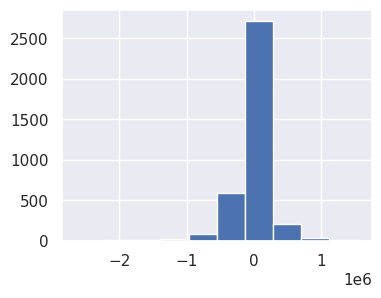

In [ ]:
val['error'].hist()

In [ ]:
val['error'].median()

5445.640270488686

In [ ]:
val['error'].mean()

-17967.745943169237

In [ ]:
model.get_feature_importance(prettified = True)

,Feature Id,Importances
0,Distance,15.958608
1,Rooms,13.006221
2,Type,11.735600
3,CouncilArea,9.390876
4,Landsize,8.529101
5,Regionname,8.475889
6,BuildingArea,7.125831
7,Postcode,6.617104
8,Bathroom,4.788538
9,SellerG,3.551472


In [ ]:
train.isna().mean().reset_index().sort_values(by = 0, ascending = False)

,index,0
14,BuildingArea,0.579495
15,YearBuilt,0.515069
13,Landsize,0.262195
12,Car,0.196680
11,Bathroom,0.190693
10,Bedroom2,0.190625
18,Longtitude,0.183550
17,Lattitude,0.183550
20,Propertycount,0.000000
19,Regionname,0.000000


# Итерация 9. Обучение на Топ-10 фичах по get_feature_importance

Уберем фичи:

YearBuilt  
Suburb  
Method  
Car  
Bedroom2


В 3 из 5 этих фичей есть пропуски, еще и в приличном кол-ве


In [ ]:
X = ['Rooms', 'Type', 'SellerG',
       'Distance', 'Postcode', 'Bathroom',
     'Landsize', 'BuildingArea', 'CouncilArea',
     'Regionname', 'Propertycount']

cat_features = ['Type', 'SellerG', 'Postcode',
                'CouncilArea', 'Regionname',
                ]

y = ['Price']

In [ ]:
train = pd.read_csv('/content/regression/train.csv')
train['Postcode'] = train['Postcode'].astype(int)

In [ ]:
test = pd.read_csv('/content/regression/test.csv')
test[cat_features] = test[cat_features].fillna(0)
test['Postcode'] = test['Postcode'].astype(int)

In [ ]:
train.loc[train['YearBuilt'] <= 1847, 'YearBuilt'] = 1847
test.loc[test['YearBuilt'] <= 1847, 'YearBuilt'] = 1847

In [ ]:
# делаю валидационную выборку для оценки и проверки
val, train = train_test_split(train, train_size=0.2, random_state=91)

val[cat_features] = val[cat_features].fillna(0)
train[cat_features] = train[cat_features].fillna(0)

Сделал прогон с подбором параметров через grid с сеткой:



```
grid = {'learning_rate': [0,15, 0.12, 0.125],
        'depth': [5, 6]}.
```




Лучшие варианты параметров не изменились, не смотря на уменьшение кол-во фичей. `{'depth': 6, 'learning_rate': 0.12}`. Поэтому прописываем их в параметры модели.

In [ ]:
parameters = {'cat_features': cat_features,
              'loss_function': 'MAE',
              'eval_metric': 'MAPE',
              'learning_rate': 0.12,
              'depth': 6,
              'random_seed':7374,
              'verbose':100}

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y],eval_set=(val[X],val[y]))

0:	learn: 0.3906042	test: 0.3910161	best: 0.3910161 (0)	total: 16.5ms	remaining: 16.5s
100:	learn: 0.1564476	test: 0.1586534	best: 0.1586534 (100)	total: 1.42s	remaining: 12.6s
200:	learn: 0.1456543	test: 0.1527619	best: 0.1527491 (199)	total: 2.77s	remaining: 11s
300:	learn: 0.1395537	test: 0.1510727	best: 0.1510362 (298)	total: 4.06s	remaining: 9.43s
400:	learn: 0.1349718	test: 0.1504226	best: 0.1503405 (390)	total: 5.32s	remaining: 7.95s
500:	learn: 0.1319335	test: 0.1499497	best: 0.1499497 (500)	total: 7.22s	remaining: 7.19s
600:	learn: 0.1296094	test: 0.1494327	best: 0.1494266 (598)	total: 8.49s	remaining: 5.63s
700:	learn: 0.1275122	test: 0.1494038	best: 0.1493391 (644)	total: 9.83s	remaining: 4.19s
800:	learn: 0.1259993	test: 0.1492388	best: 0.1492202 (789)	total: 11.1s	remaining: 2.76s
900:	learn: 0.1247523	test: 0.1492654	best: 0.1492202 (789)	total: 12.3s	remaining: 1.36s
999:	learn: 0.1234913	test: 0.1490763	best: 0.1490686 (996)	total: 13.6s	remaining: 0us

bestTest = 0.149

In [ ]:
val['Price_pred_it1_1'] = model.predict(val[X])

In [ ]:
error(val['Price'],val['Price_pred_it1_1'])

167607.98388152834
0.14906855585045342


Попробуем обучить с этим набором фич/параметров модель на всех train данных и сделать еще сабмит

In [ ]:
train = pd.read_csv('/content/regression/train.csv')

train['Postcode'] = train['Postcode'].astype(int)
train[cat_features] = train[cat_features].fillna(0)

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y])

0:	learn: 0.3907224	total: 16.5ms	remaining: 16.5s
100:	learn: 0.1570034	total: 1.88s	remaining: 16.7s
200:	learn: 0.1461900	total: 3.64s	remaining: 14.5s
300:	learn: 0.1408177	total: 5.1s	remaining: 11.8s
400:	learn: 0.1371871	total: 6.59s	remaining: 9.84s
500:	learn: 0.1341677	total: 8.1s	remaining: 8.06s
600:	learn: 0.1318692	total: 9.57s	remaining: 6.35s
700:	learn: 0.1299478	total: 11.1s	remaining: 4.71s
800:	learn: 0.1283083	total: 12.9s	remaining: 3.2s
900:	learn: 0.1268365	total: 14.6s	remaining: 1.6s
999:	learn: 0.1256965	total: 16.1s	remaining: 0us


In [ ]:
test['Price'] = model.predict(test[X])

In [ ]:
test[['id', 'Price']].to_csv('it_8_1(rd91).csv', index = False)

Score: **13.97131**

Уменьшение кол-ва фичей в моделе не дало прироста в точности

При этом изменения random_seed при делении выборки, никак не повлияло на результат модели

# Результаты

На момент написания удалось занять в уютном соревновании среди новичков **14 место из 140 участников**.

Считаю результат неплохим. Получил ценный опыт, потому что это буквально первая подобная моя актвиность. По мере получения новых скиллов планирую еще раз ворваться и попытаться улучшить результат

https://www.kaggle.com/competitions/leopard-challenge-regression/leaderboard